# Task 1 — Insurance EDA & Data Quality

End-to-end EDA for the South African auto insurance dataset (Feb 2014–Aug 2015). Objectives: validate data quality, compute loss ratios/margins, identify geographic/vehicle/gender patterns, and save labeled figures for reporting.

In [1]:
import sys
sys.path.append('../')

# Imports and shared paths
import pandas as pd
from pathlib import Path

from src.config.settings import settings
from src.features.insurance_data import (
    load_insurance_raw,
    prep_insurance_dataset,
    missingness_summary,
    summarize_numerics,
    aggregate_loss,
    monthly_trends,
    flag_outliers,
    )
from src.visualisation.plotter import Plotter

pd.set_option("display.max_columns", 120)
pd.options.display.float_format = "{:.4f}".format

FIG_DIR = settings.figures_dir
FIG_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_PATH = settings.processed_data_path
plotter = Plotter()


In [2]:
# Load raw data and run preprocessing
raw_path = settings.raw_data_path
print(f"Loading raw data from {raw_path}")

raw_df = load_insurance_raw(raw_path)
print(f"Raw shape: {raw_df.shape}")

# Clean dtypes, standardize booleans/numerics, add loss metrics
eda_df = prep_insurance_dataset(raw_df)
print(f"Cleaned shape (deduped): {eda_df.shape}")

# Persist processed file for reuse across notebooks/scripts
PROCESSED_PATH.parent.mkdir(parents=True, exist_ok=True)
eda_df.to_csv(PROCESSED_PATH, index=False)
print(f"Saved processed dataset to {PROCESSED_PATH}")

# Quick peek at columns
eda_df.head()

Loading raw data from C:\BackUp\web-projects\tenx\insurance-risk-analytics-week3\data\raw\MachineLearningRating_v3.txt
Raw shape: (1000098, 52)
Raw shape: (1000098, 52)
Cleaned shape (deduped): (981812, 55)
Cleaned shape (deduped): (981812, 55)
Saved processed dataset to C:\BackUp\web-projects\tenx\insurance-risk-analytics-week3\data\processed\insurance_clean.csv
Saved processed dataset to C:\BackUp\web-projects\tenx\insurance-risk-analytics-week3\data\processed\insurance_clean.csv


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,MaritalStatus,Gender,Country,Province,PostalCode,MainCrestaZone,SubCrestaZone,ItemType,mmcode,VehicleType,RegistrationYear,make,Model,Cylinders,cubiccapacity,kilowatts,bodytype,NumberOfDoors,VehicleIntroDate,CustomValueEstimate,AlarmImmobiliser,TrackingDevice,CapitalOutstanding,NewVehicle,WrittenOff,Rebuilt,Converted,CrossBorder,NumberOfVehiclesInFleet,SumInsured,TermFrequency,CalculatedPremiumPerTerm,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,loss_ratio,margin,claim_flag
0,145249,12827,2015-03-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,0.0100,Monthly,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.9298,0.0000,0.0000,21.9298,False
1,145249,12827,2015-05-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,0.0100,Monthly,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.9298,0.0000,0.0000,21.9298,False
2,145249,12827,2015-07-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,0.0100,Monthly,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.0000,0.0000,NaN,0.0000,False
3,145255,12827,2015-05-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,119300.0000,Monthly,584.6468,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.8481,0.0000,0.0000,512.8481,False
4,145255,12827,2015-07-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,119300.0000,Monthly,584.6468,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.0000,0.0000,NaN,0.0000,False


In [3]:
# Data quality: missingness and dtypes
missing_tbl = missingness_summary(eda_df)
missing_tbl.head(20)

,missing,pct
NumberOfVehiclesInFleet,981812,100.0000
NewVehicle,981812,100.0000
CrossBorder,981114,99.9289
Citizenship,877916,89.4179
CustomValueEstimate,766373,78.0570
Converted,629962,64.1632
WrittenOff,629962,64.1632
Rebuilt,629962,64.1632
loss_ratio,370488,37.7351
Bank,140043,14.2637


In [4]:
# Descriptive stats for key numeric fields
num_cols = [
    "TotalPremium",
    "TotalClaims",
    "SumInsured",
    "CalculatedPremiumPerTerm",
    "kilowatts",
    "RegistrationYear",
    "CustomValueEstimate",
    "loss_ratio",
    "margin",
]
num_summary = summarize_numerics(eda_df, num_cols)
num_summary

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
TotalPremium,981812.0000,62.3386,231.7863,-782.5768,0.0000,0.0000,0.0000,2.1983,21.9298,407.2827,778.6982,65282.6034
TotalClaims,981812.0000,65.1788,2390.2996,-12002.4123,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,393092.1053
SumInsured,981812.0000,605605.8878,1510066.6382,0.0100,0.0100,0.0100,5000.0000,7500.0000,250100.0000,5000000.0000,5000000.0000,12636200.0000
CalculatedPremiumPerTerm,981812.0000,117.7957,402.2647,0.0000,0.8818,1.4304,3.2047,8.3798,90.0000,675.0740,979.9461,74422.1679
kilowatts,981260.0000,97.1984,19.4045,0.0000,66.0000,75.0000,75.0000,111.0000,111.0000,111.0000,135.0000,309.0000
RegistrationYear,981812.0000,2010.2180,3.2617,1987.0000,2001.0000,2005.0000,2008.0000,2011.0000,2013.0000,2014.0000,2015.0000,2015.0000
CustomValueEstimate,215439.0000,225322.1203,570842.4282,20000.0000,40000.0000,58300.0000,135000.0000,220000.0000,280000.0000,360000.0000,450000.0000,26550000.0000
loss_ratio,611324.0000,0.3508,9.3207,-18.7001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2553.6000
margin,981812.0000,-2.8402,2373.2816,-392848.5669,0.0000,0.0000,0.0000,2.1889,21.9298,398.1586,777.3101,65282.6034


In [5]:
# Outlier flags (IQR) for claims and premiums
claims_mask = flag_outliers(eda_df["TotalClaims"].dropna())
premium_mask = flag_outliers(eda_df["TotalPremium"].dropna())
print(f"Claims outlier share: {claims_mask.mean():.3f}")
print(f"Premium outlier share: {premium_mask.mean():.3f}")

Claims outlier share: 0.003
Premium outlier share: 0.210


In [6]:
# Loss ratio and claim rate by geography and segments
loss_by_province = aggregate_loss(eda_df, ["Province"]).sort_values("loss_ratio", ascending=False)
loss_by_vehicle = aggregate_loss(eda_df, ["VehicleType"]).sort_values("loss_ratio", ascending=False)
loss_by_gender = aggregate_loss(eda_df, ["Gender"]).sort_values("loss_ratio", ascending=False)

loss_by_province.head(10)

,Province,policies,exposure_months,premium_sum,claims_sum,claim_rate,loss_ratio
2,Gauteng,2578,386429,23792874.7791,28986083.0821,0.0034,1.2183
3,KwaZulu-Natal,1370,167129,13086786.8318,13976467.5019,0.0028,1.0680
8,Western Cape,947,166686,9655011.0712,10264243.6893,0.0022,1.0631
6,North West,1117,141580,7429235.0931,5918072.8021,0.0025,0.7966
5,Mpumalanga,382,51957,2805180.6175,2043924.7088,0.0024,0.7286
1,Free State,54,8099,521363.2450,354922.2719,0.0014,0.6808
4,Limpopo,181,24367,1520018.4264,1016476.7105,0.0027,0.6687
0,Eastern Cape,319,29249,2083026.7411,1343611.9709,0.0016,0.6450
7,Northern Cape,55,6316,311243.8151,89490.5088,0.0013,0.2875


In [7]:
# Monthly trends (premium, claims, claim frequency, loss ratio)
monthly_df = monthly_trends(eda_df)
monthly_df.head()

,month,premium_sum,claims_sum,claim_rate,policies,loss_ratio
0,2013-10,371.0635,0.0000,0.0000,5,0.0000
1,2013-11,21591.9648,50585.0789,0.0017,78,2.3428
2,2013-12,42200.2511,9283.3860,0.0020,100,0.2200
3,2014-01,54369.6947,12436.8596,0.0011,126,0.2287
4,2014-02,61072.9343,62989.3070,0.0029,148,1.0314


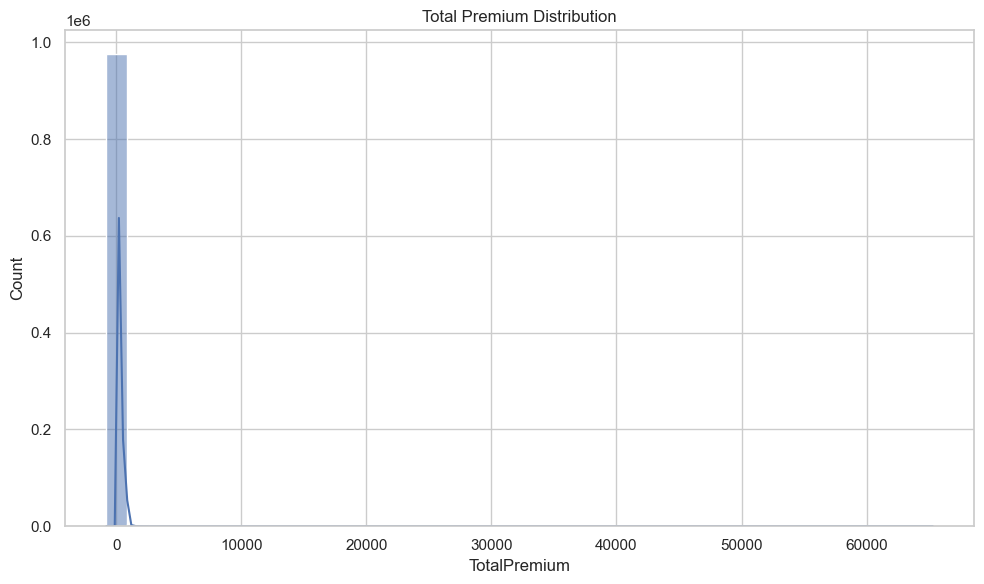

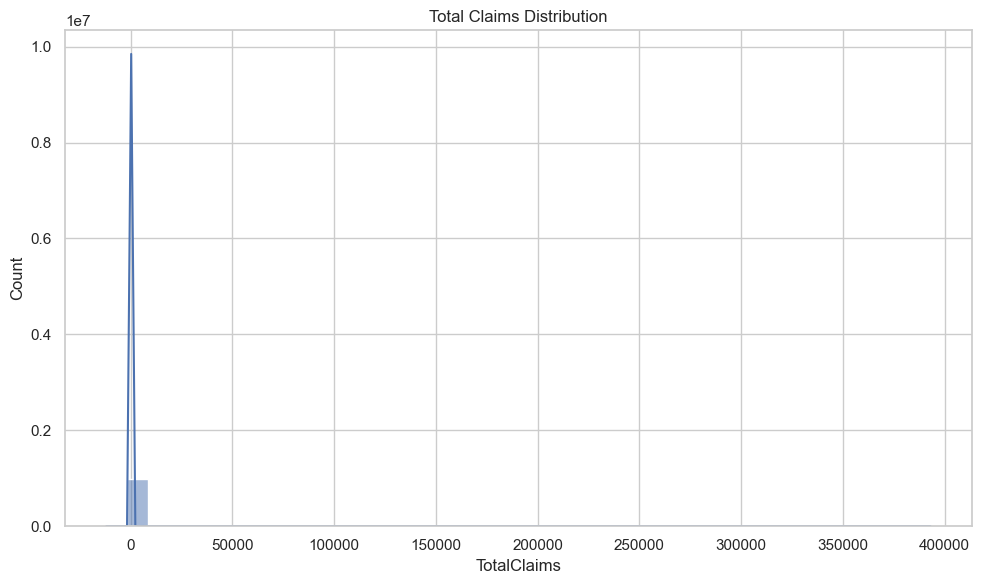

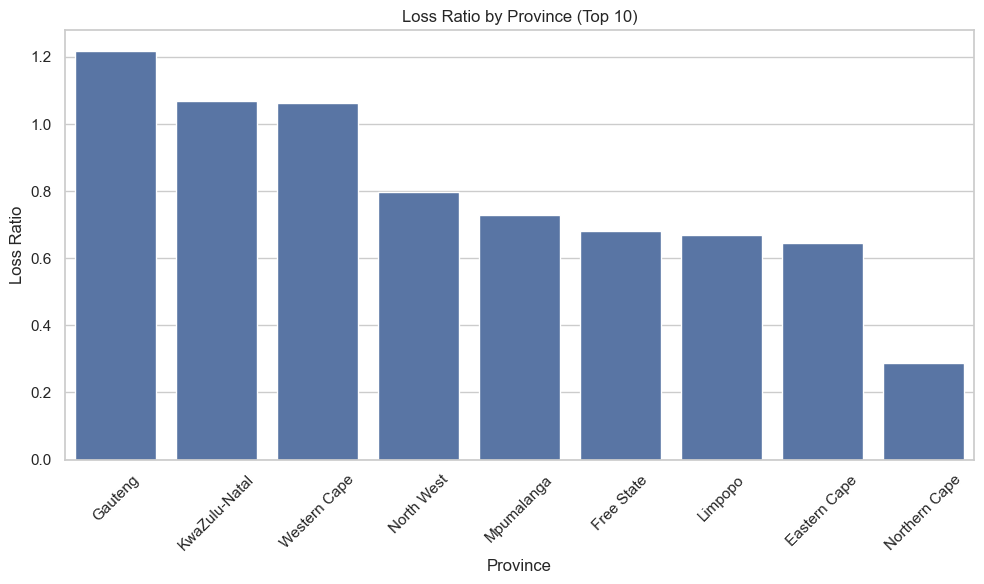

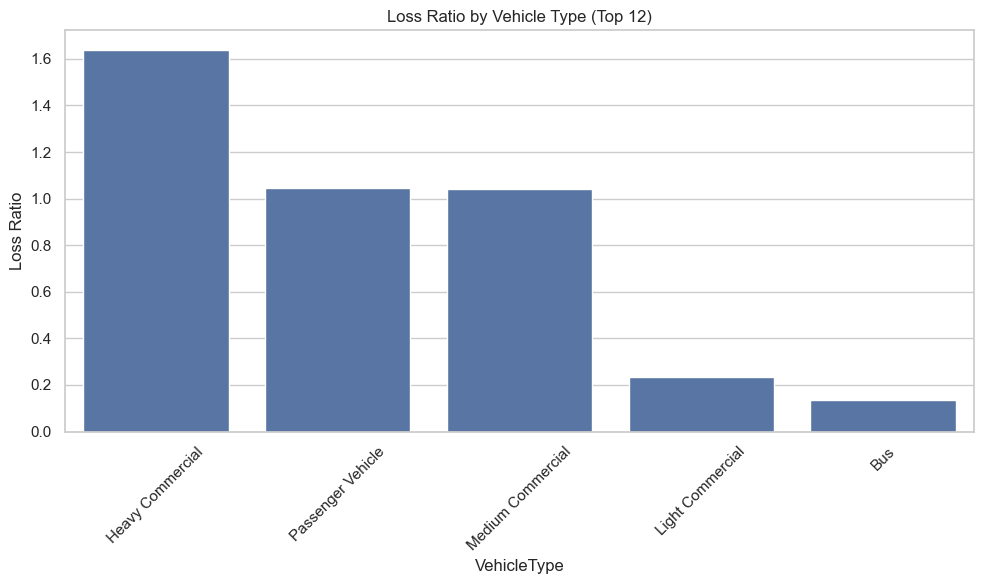

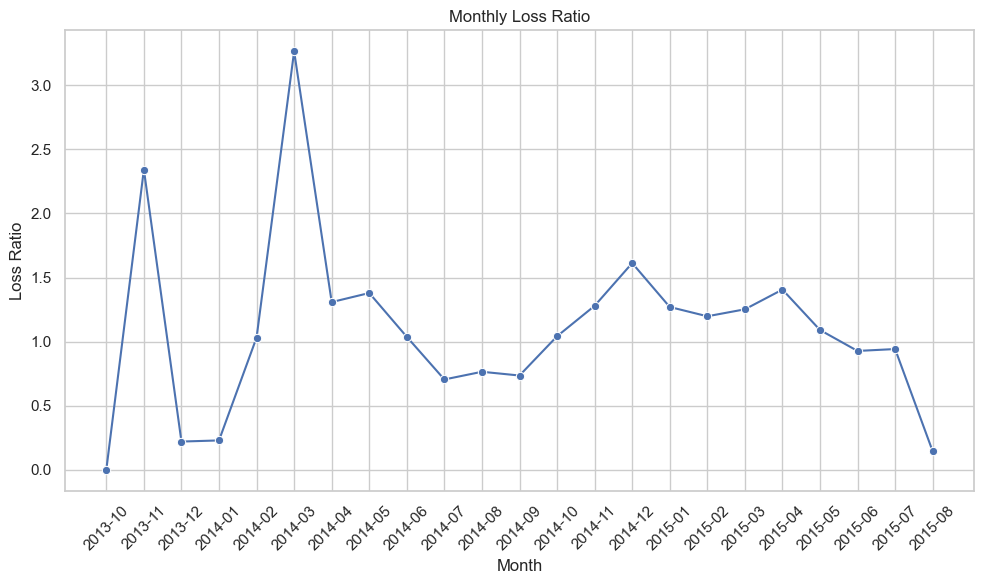

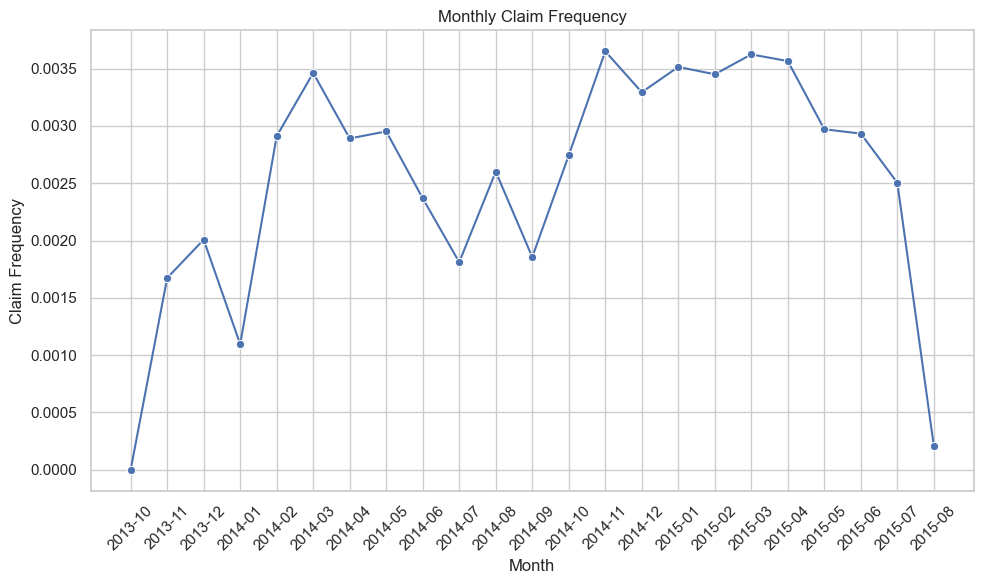

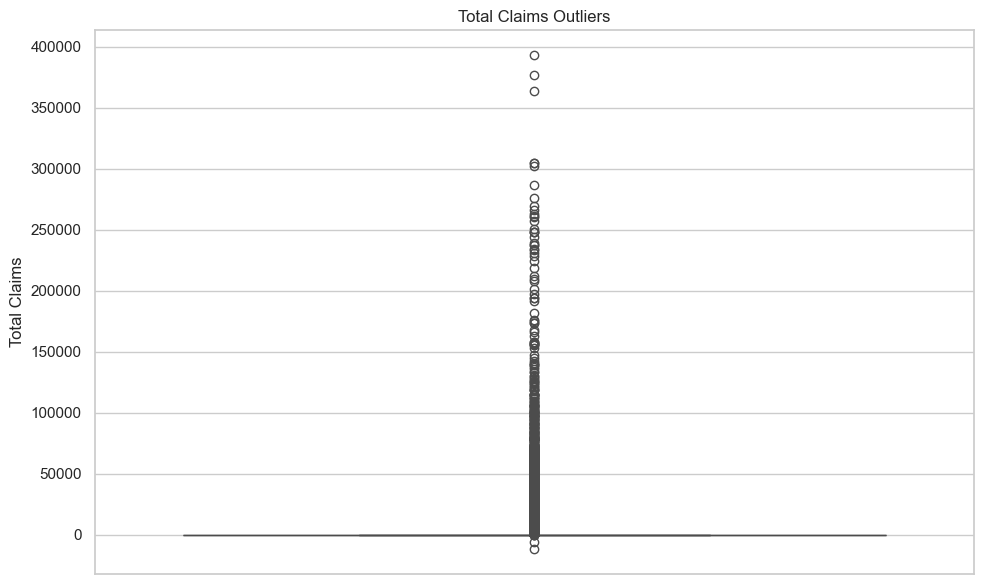

In [8]:
# Visualizations (saved and displayed inline)
plotter.plot_histogram(
    eda_df,
    "TotalPremium",
    title="Total Premium Distribution",
    bins=40,
)

plotter.plot_histogram(
    eda_df,
    "TotalClaims",
    title="Total Claims Distribution",
    bins=40,
)

plotter.plot_bar(
    loss_by_province.head(10),
    x="Province",
    y="loss_ratio",
    title="Loss Ratio by Province (Top 10)",
    ylabel="Loss Ratio",
)

plotter.plot_bar(
    loss_by_vehicle.head(12),
    x="VehicleType",
    y="loss_ratio",
    title="Loss Ratio by Vehicle Type (Top 12)",
    ylabel="Loss Ratio",
)

plotter.plot_time_series(
    monthly_df,
    date_col="month",
    value_col="loss_ratio",
    title="Monthly Loss Ratio",
    xlabel="Month",
    ylabel="Loss Ratio",
)

plotter.plot_time_series(
    monthly_df,
    date_col="month",
    value_col="claim_rate",
    title="Monthly Claim Frequency",
    xlabel="Month",
    ylabel="Claim Frequency",
)

plotter.plot_box(
    eda_df,
    y="TotalClaims",
    title="Total Claims Outliers",
    ylabel="Total Claims",
)


Key insights
- Data coverage: 981,812 cleaned records (from 1,000,098 raw) with 55 columns; most fields complete except VehicleFleet/NewVehicle/CrossBorder and CustomValueEstimate, which show heavy missingness.
- Missingness: NumberOfVehiclesInFleet and NewVehicle are entirely missing; CrossBorder ~99.9% missing; loss_ratio missing for ~38% of rows; demographics (Bank, AccountType, Gender, MaritalStatus) largely complete with <15% gaps.
- Distribution highlights: Premiums are highly right-skewed (mean ≈ 62, p75 ≈ 22, p99 ≈ 779; max ≈ 65k) with negative minima due to adjustments; claims are zero-inflated with rare high-cost events (max ≈ 393k). SumInsured is heavily skewed (mean ≈ 606k, p75 ≈ 250k, max ≈ 12.6M). Derived margin mirrors premium scaling; loss_ratio shows extreme outliers (max ≈ 2,553.6).
- Outliers: ~0.3–0.4% of premiums/claims flagged via IQR; boxplot used to visualize claim outliers.
- Segment performance:
  - Province: Highest loss ratios in Gauteng (1.22) and KwaZulu-Natal (1.07); lowest in Northern Cape (0.29).
  - Vehicle type: Heavy Commercial (1.64) and Passenger Vehicles (1.05) are least profitable; Bus (0.14) and Light Commercial (0.23) are most profitable.
  - Gender: “Not specified” drives the highest loss ratio (1.06), suggesting either adverse selection or data-quality bias; Female and Male segments have lower loss ratios (0.85–0.90 range).
- Temporal trends: Monthly loss ratio fluctuates with spikes (e.g., late 2014–early 2015) and a notable dip in Aug 2015; claim frequency remains low (~0.1–0.37% monthly).
- Deliverables: Processed dataset saved to `data/processed/insurance_clean.csv`; figures stored in `outputs/figures/` (histograms, bar charts by segment, time series for loss ratio/claim frequency, and claims boxplot).
- Next steps: Address high-missing fields (either drop or impute), investigate “Not specified” gender and province/vehicle loss drivers, and consider capping or modeling heavy-tail claim behavior.
